In [2]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## radius neighbors
from sklearn.ensemble import ExtraTreesClassifier
# perso utils
from utils import load_data, SEED, NJOBS, dict_equality
NJOBS = 1

# get the data
X_train, X_test, Y_train, Y_test = load_data(test_size=.2, train_size=1000)

# scoring metrics
scoring = 'f1_weighted'


In [3]:
# rescaling the data
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

In [10]:
## model specification ##
model = ExtraTreesClassifier(n_estimators=500)

# hyper parameter space
param_grid = {
    'max_depth': np.round(np.linspace(2, 100, 15), 0).astype(int),
    'criterion' : ['gini', 'entropy'],
}

# fit the data
search_model = GridSearchCV(
    model, 
    param_grid, 
    scoring=scoring, 
    n_jobs=NJOBS,
    return_train_score=True,
)

fit = True
save = True

if fit :
    # fit the model 
    search_model.fit(X_train, Y_train)

    if save : 
        # save the model 
        with open('pkl/extratrees.pkl', 'wb') as f :
            pickle.dump(search_model, f)

else : 
    # load the model
    with open('pkl/extratrees.pkl', 'rb') as f :
        search_model = pickle.load(f)

    old_grid = param_grid
    param_grid = search_model.param_grid
    
    if not dict_equality(old_grid, param_grid) : 
        print('warning, param_grid changed\nthe one of the model : ')
        print(param_grid)

### results

In [11]:
print("Best Score: ", search_model.best_score_)
print("Best Params: ", search_model.best_params_, '\n')

res = search_model.cv_results_
df_res = pd.DataFrame(res)
# df_res.head()

Best Score:  0.9555216942642817
Best Params:  {'criterion': 'gini', 'max_depth': 16} 



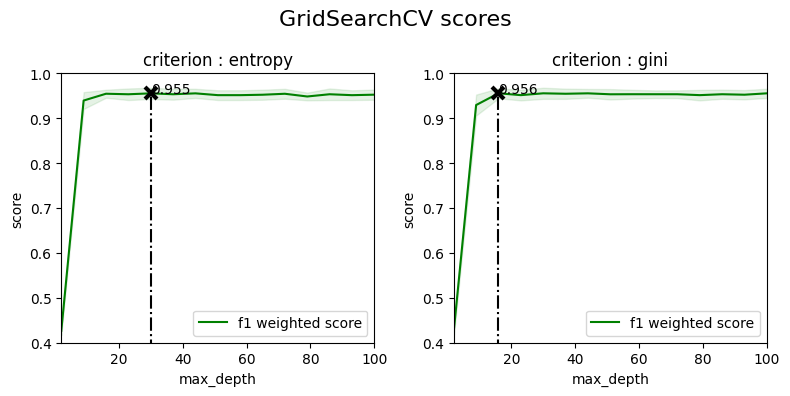

In [13]:
x_name = 'max_depth'
xs = param_grid[x_name]
param1_name = 'criterion'
param2_name = None

col_names = ['param_'+x_name]
if param1_name is not None: col_names.append('param_'+param1_name)
if param2_name is not None: col_names.append('param_'+param2_name)
col_names.extend(['mean_test_score', 'std_test_score'])

df_interest = df_res[col_names]

nrows = len(param_grid[param2_name]) if param2_name is not None else 1
ncols = len(param_grid[param1_name]) if param1_name is not None else 1

fig = plt.figure(figsize=(4*ncols, 4*nrows))
fig.suptitle('GridSearchCV scores', fontsize=16)


if param2_name is None and param1_name is None :
    df = df_interest.sort_values(by=['param_'+x_name])

    score = df['mean_test_score'].to_numpy(dtype=float)
    std = df['std_test_score'].to_numpy(dtype=float)


    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    fig.suptitle('GridSearchCV scores', fontsize=16)


    ax.set_xlim(min(xs), max(xs))
    ax.set_ylim(.4, 1)

    ax.plot(xs, score, color='g', label='f1 weighted score')
    ax.fill_between(xs, score-std, score+std, alpha=.4, color='g')

    best_index = np.where(score == max(score))[0][0]
    b_x = xs[best_index]
    b_score = score[best_index]

    ax.plot([b_x]*2, [0, b_score], linestyle="-.", color='black', marker="x", markeredgewidth=3, ms=8)

    ax.set_xlabel(x_name)
    ax.set_ylabel('score')
    ax.legend()

elif param2_name is None :
    group_by = ['param_' + param1_name]   
else : 
    group_by = ['param_'+param1_name, 'param_'+param2_name]



for i, (group, df) in enumerate(df_interest.groupby(by=group_by)) :
    df = df.sort_values(by=['param_'+x_name])

    score = df['mean_test_score'].to_numpy(dtype=float)
    std = df['std_test_score'].to_numpy(dtype=float)
    

    if i == 0 :
        ax = fig.add_subplot(nrows, ncols, i+1)
    else :
        ax = fig.add_subplot(nrows, ncols, i+1, sharex=ax0, sharey=ax0)


    ax.set_xlim(min(xs), max(xs))
    ax.set_ylim(.4, 1)

    ax.plot(xs, score, color='g', label='f1 weighted score')
    ax.fill_between(xs, score-std, score+std, alpha=.1, color='g')

    best_index = np.where(score == max(score))[0][0]
    b_x = xs[best_index]
    b_score = score[best_index]

    ax.plot([b_x]*2, [0, b_score], linestyle="-.", color='black', marker="x", markeredgewidth=3, ms=8)

    if param2_name is not None :
        ax.set_title('{} : {} ; {} : {}'.format(param1_name, group[0], param2_name, group[1]))
    else  :
        ax.set_title('{} : {}'.format(param1_name, group[0]))
        
    ax.text(b_x, b_score, '{:.3f}'.format(b_score))
    ax.set_xlabel(x_name)
    ax.set_ylabel('score')
    ax.legend()

    if i == 0 : ax0 = ax
    
fig.tight_layout()
fig.savefig('fig/knn.png')
